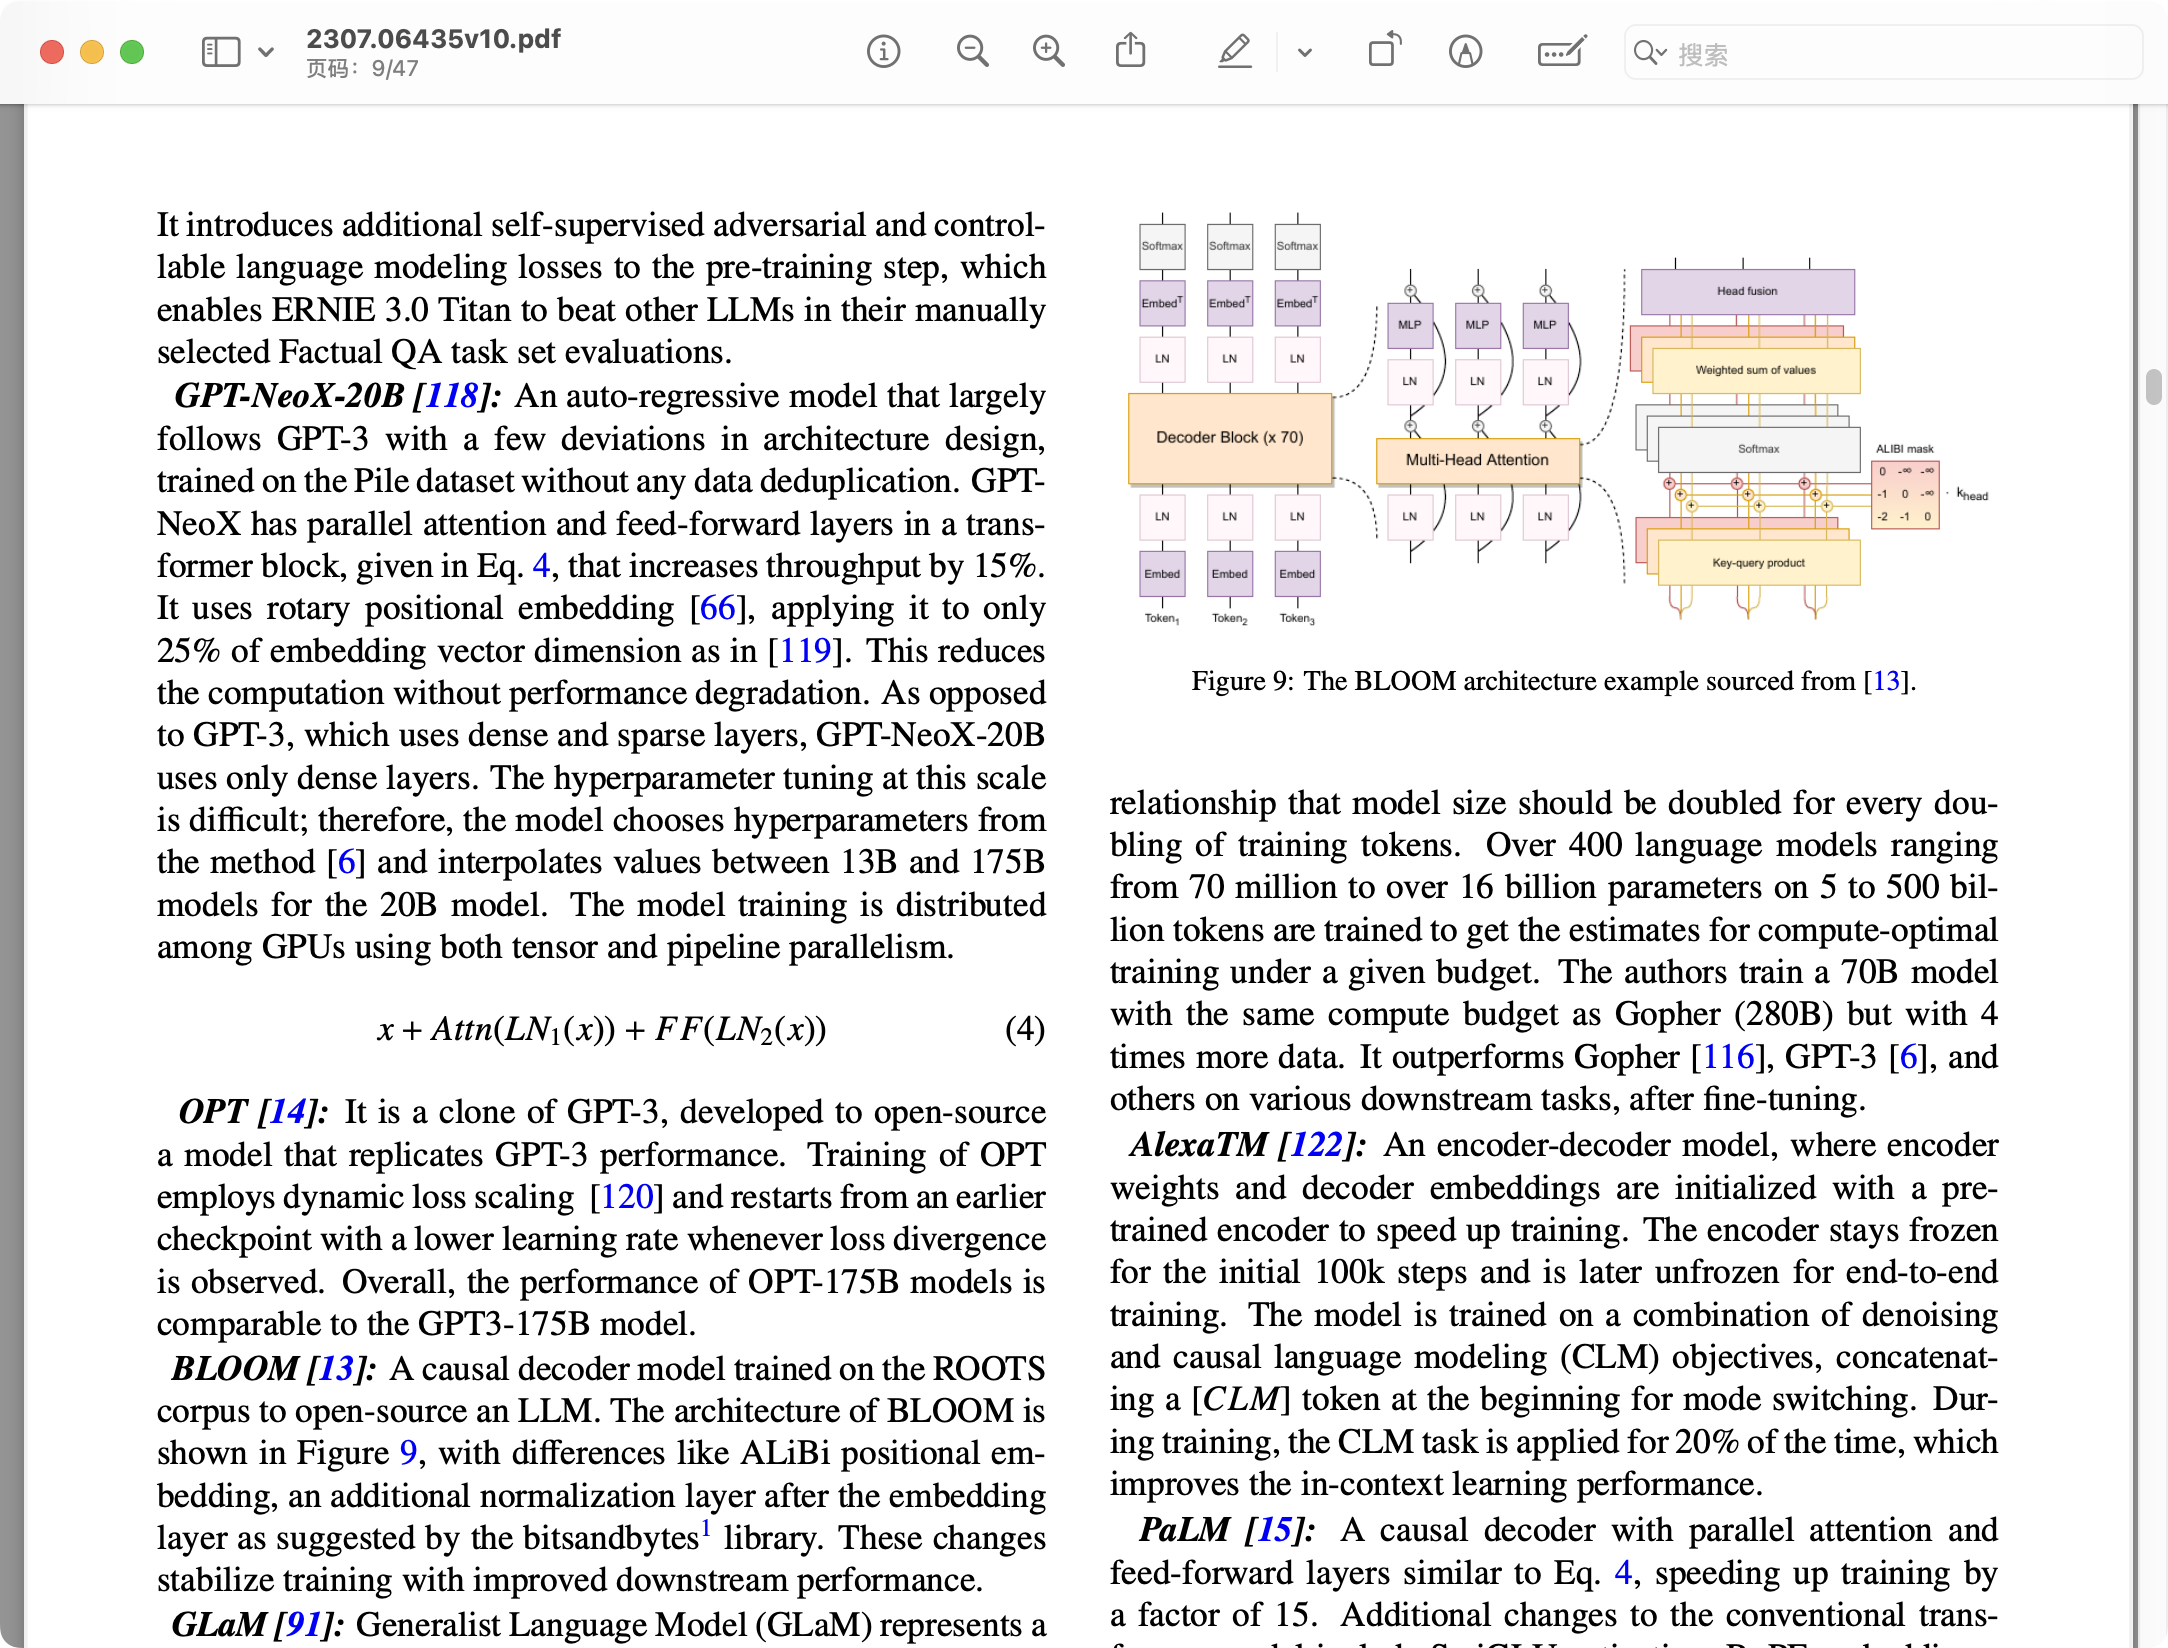

## 问题背景

RAG（Retrieval-Augmented Generation，检索增强生成）模型是一种结合了检索和生成能力的架构，广泛应用于问答系统、文本生成等任务中。然而，在实际应用中，模型可能会遇到包含复杂格式、图表和图像的文档。这些复杂文档不仅包含大量的文本内容，还可能涉及多种视觉元素，如表格、图形、图片等，这些元素往往蕴含着关键信息。

In [ ]:
document analysis

## 方法1：pymupdf

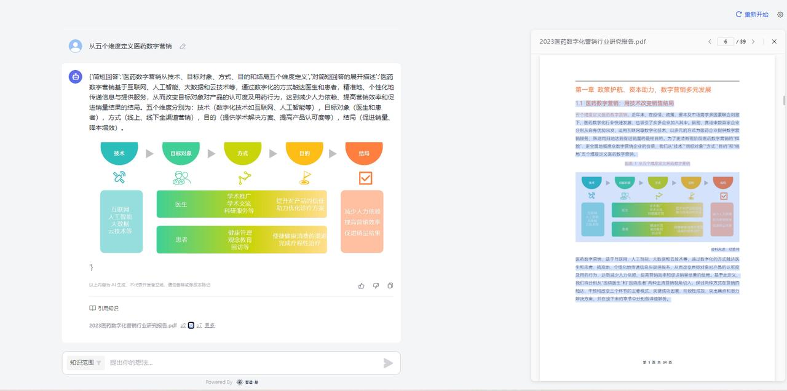

In [3]:
import pymupdf, fitz

def extract_first_page_content(pdf_path):
    # 打开PDF文件
    doc = fitz.open(pdf_path)
    
    # 获取第一页
    page = doc[0]
    
    print(f"正在处理PDF第一页，页面尺寸: {page.rect}")
    
    # 1. 提取所有文本
    print("\n=== 文本内容 ===")
    text = page.get_text()
    print(text)
    
    # 2. 提取所有图片
    print("\n=== 图片信息 ===")
    image_list = page.get_images(full=True)
    
    if image_list:
        print(f"发现 {len(image_list)} 张图片")
    else:
        print("本页没有发现图片")
    
    # 3. 提取表格（需要转换为文本表格）
    print("\n=== 表格内容 ===")
    # PyMuPDF本身不直接识别表格，但可以通过文本块分析来提取表格数据
    # 这里使用get_text("blocks")获取文本块，然后尝试识别表格结构
    
    blocks = page.get_text("blocks")
    tables = []
    current_table = []
    
    # 简单的表格识别逻辑（实际应用中可能需要更复杂的算法）
    for block in blocks:
        x0, y0, x1, y1, text, block_no, block_type = block
        if "\t" in text or "  " in text:  # 简单的表格行识别
            current_table.append(text.strip().split("\t"))
        elif current_table:
            tables.append(current_table)
            current_table = []
    
    if current_table:  # 添加最后一个表格
        tables.append(current_table)
    
    if tables:
        print(f"发现 {len(tables)} 个表格")
        for i, table in enumerate(tables, 1):
            print(f"\n表格 {i}:")
            for row in table:
                print(" | ".join(row))
    else:
        print("本页没有发现明显的表格结构")
    
    # 关闭文档
    doc.close()

# 使用示例
pdf_file = "./data/2307.06435v10.pdf"  # 替换为你的PDF文件路径
extract_first_page_content(pdf_file)

正在处理PDF第一页，页面尺寸: Rect(0.0, 0.0, 595.2760009765625, 841.8900146484375)

=== 文本内容 ===
A Comprehensive Overview of Large Language Models
Humza Naveeda, Asad Ullah Khanb,∗, Shi Qiuc,∗, Muhammad Saqibd,e,∗, Saeed Anwarf,g, Muhammad Usmanf,g, Naveed Akhtarh,j,
Nick Barnesi, Ajmal Mianj
aThe University of Sydney, Sydney, Australia
bUniversity of Engineering and Technology (UET), Lahore, Pakistan
cThe Chinese University of Hong Kong (CUHK), HKSAR, China
dUniversity of Technology Sydney (UTS), Sydney, Australia
eCommonwealth Scientific and Industrial Research Organisation (CSIRO), Sydney, Australia
fKing Fahd University of Petroleum and Minerals (KFUPM), Dhahran, Saudi Arabia
gSDAIA-KFUPM Joint Research Center for Artificial Intelligence (JRCAI), Dhahran, Saudi Arabia
hThe University of Melbourne (UoM), Melbourne, Australia
iAustralian National University (ANU), Canberra, Australia
jThe University of Western Australia (UWA), Perth, Australia
Abstract
Large Language Models (LLMs) have recently d

## 方法2：MathPix APi

## 方法3：Qwen-VL

In [4]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "model/Qwen2.5-VL-7B-Instruct/", torch_dtype="auto", device_map="auto"
)

# default processer
processor = AutoProcessor.from_pretrained("model/Qwen2.5-VL-7B-Instruct/")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


["The image depicts a serene beach scene during what appears to be either sunrise or sunset, as indicated by the warm, golden light illuminating the sky and casting long shadows on the sand. A woman is sitting on the sandy beach, wearing a plaid shirt and dark pants, with her legs crossed. She has long hair and is smiling warmly at a light-colored dog, possibly a Labrador Retriever, which is sitting in front of her. The dog is wearing a harness and is extending its paw towards the woman's hand, suggesting a playful interaction between them. The ocean is visible in the background, with gentle waves rolling onto the shore"]


In [5]:
doc = fitz.open("./data/2307.06435v10.pdf")

page = doc[0]
text = page.get_text()
print(text)

A Comprehensive Overview of Large Language Models
Humza Naveeda, Asad Ullah Khanb,∗, Shi Qiuc,∗, Muhammad Saqibd,e,∗, Saeed Anwarf,g, Muhammad Usmanf,g, Naveed Akhtarh,j,
Nick Barnesi, Ajmal Mianj
aThe University of Sydney, Sydney, Australia
bUniversity of Engineering and Technology (UET), Lahore, Pakistan
cThe Chinese University of Hong Kong (CUHK), HKSAR, China
dUniversity of Technology Sydney (UTS), Sydney, Australia
eCommonwealth Scientific and Industrial Research Organisation (CSIRO), Sydney, Australia
fKing Fahd University of Petroleum and Minerals (KFUPM), Dhahran, Saudi Arabia
gSDAIA-KFUPM Joint Research Center for Artificial Intelligence (JRCAI), Dhahran, Saudi Arabia
hThe University of Melbourne (UoM), Melbourne, Australia
iAustralian National University (ANU), Canberra, Australia
jThe University of Western Australia (UWA), Perth, Australia
Abstract
Large Language Models (LLMs) have recently demonstrated remarkable capabilities in natural language processing tasks and
beyond.

In [14]:
import base64

image_list = page.get_images(full=True)
for img_index, img in enumerate(image_list, 1):
    xref = img[0]
    base_image = doc.extract_image(xref)
    image_bytes = base_image["image"]
    image_ext = base_image["ext"]
    image_base64 = base64.b64encode(image_bytes).decode("utf-8")


In [18]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"data:image/jpeg;base64,{image_base64}"
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


['The image is a bar chart titled "Papers Released over Years," which shows the number of papers released each year for three categories: LLMs (Large Language Models), LLMs + Fine-Tuning, and LLMs + Alignment. The x-axis represents the years from 2018 to 2024, while the y-axis represents the number of papers.\n\nHere\'s a breakdown of the data:\n\n- **LLMs**: \n  - 2018: 42 papers\n  - 2019: 60 papers\n  - 2020: ']
